In [19]:
import pickle
import os

FOLDER = os.getcwd() + "/2ovals"

with open(FOLDER+'/ori.pkl', 'rb') as file:   
    ori = pickle.load(file)
with open(FOLDER+'/mask.pkl', 'rb') as file:   
    mask = pickle.load(file)
with open(FOLDER+'/out.pkl', 'rb') as file:   
    out = pickle.load(file)
with open(FOLDER+'/psf.pkl', 'rb') as file:   
    psf = pickle.load(file)


In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams['figure.figsize'] = [15, 5]
import numpy as np
import time
from utils import *
from Dataloader import *
from PSFNetv2 import *

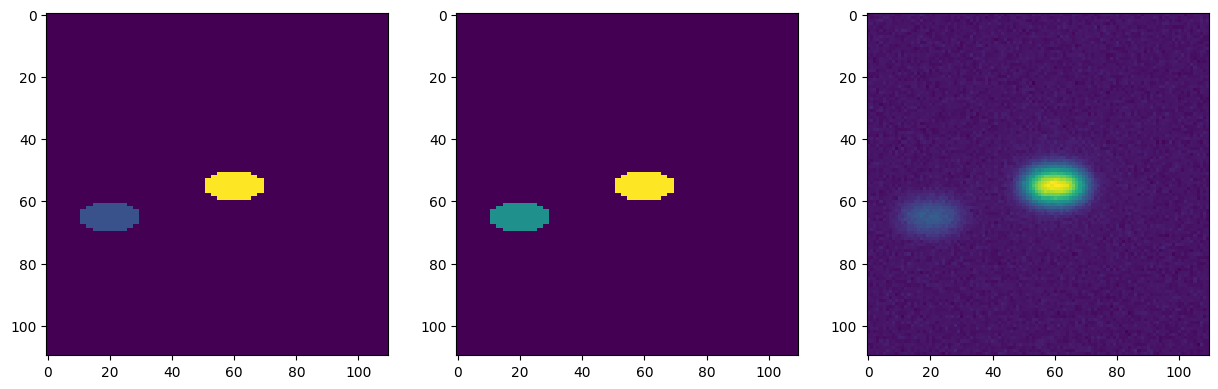

In [21]:
ori = ori/max(ori.flatten())
mask = mask/max(mask.flatten())
out = out/max(out.flatten())

f, axarr = plt.subplots(1,3)
axarr[0].imshow(ori)
axarr[1].imshow(mask)
axarr[2].imshow(out)
plt.show()

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [23]:
maskSize = np.linalg.norm(mask.shape)
sourcePts = GetSourcePts(mask,FOLDER)

#Define dataset and dataloader
dataset = Dataloader(out, mask, adjPts=4, randomPts=0)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1024, shuffle=True, num_workers=2)

#Define model
model = PSFNet(len(sourcePts),dataset.intensityMatrix.data.flatten())

#Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0)


Best scaling const is:  -1842.0699693267163


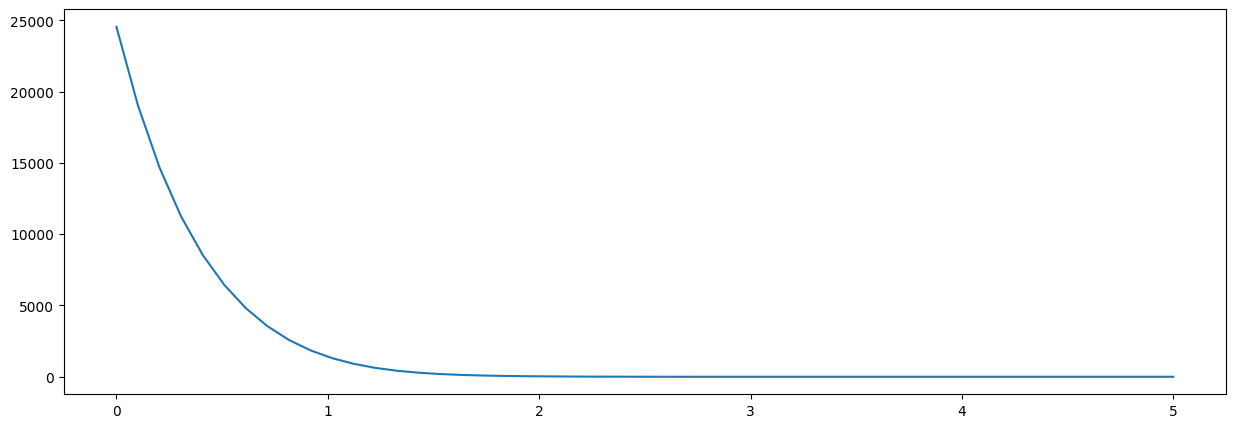

In [24]:
#Perform a global serarch on what the scaling const is
x = np.linspace(0,5,50)
y = []

for i in x:
    model.polynomial_weights.weight.data[0] = -10**i
    average_running_loss = 0
    for j, data in enumerate(dataloader):
        inputs, outputs = data
        nn_outputs = model(inputs)
        loss = criterion(nn_outputs.float(), outputs.float())
        average_running_loss += loss.item()
    average_running_loss /= len(dataloader)
    y.append(average_running_loss)

plt.plot(x,y)
model.polynomial_weights.weight.data[0] = -10**x[np.argmin(y)]
print("Best scaling const is: ", -10**x[np.argmin(y)])

In [25]:
#Training loop

timestr = time.strftime("%Y%m%d-%H%M%S")
PATH = FOLDER + "/model-"+timestr+".pt"
oldOut = out.copy()

TrainingLoop(model,dataloader,criterion,optimizer,epochs=100, minLoss=0.01)

print(model.polynomial_weights.weight.data)

oldOut = InverseMatrix(oldOut,mask,sourcePts,learningRate=1,randomPts=0,adjPts=4,model=model)
oldOut = oldOut/max(oldOut.flatten())

print('Finished Training')


Epoch:  20  Loss:  0.06180814653635025
Epoch:  40  Loss:  0.061808135360479355
Epoch:  60  Loss:  0.06180814281105995
Epoch:  80  Loss:  0.06180814281105995
Epoch:  100  Loss:  0.06180814653635025
Epoch:  100  Loss:  0.06180814653635025
tensor([[-1842.0699]])
[1.0, 0.5]
[[1.        ]
 [0.31351644]]
Finished Training


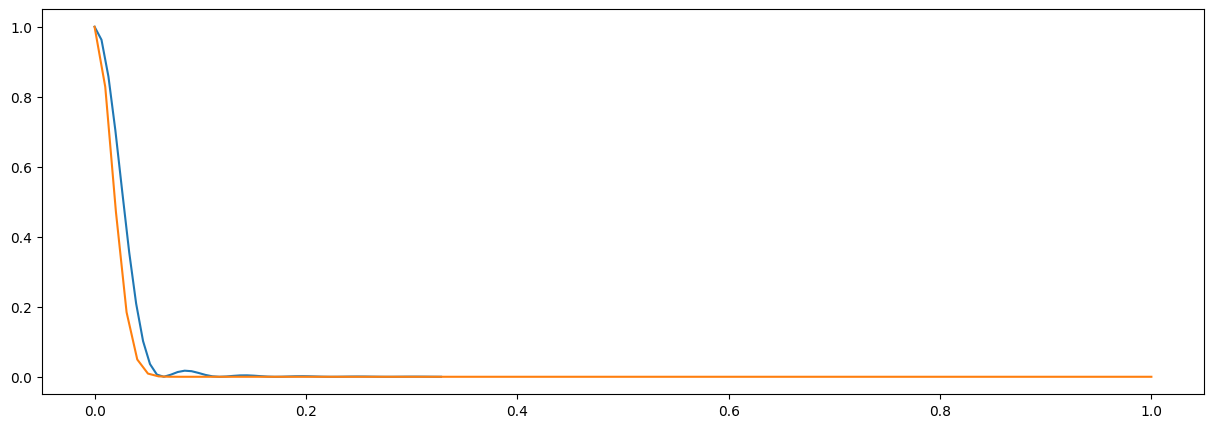

In [31]:
#Normalise x axis of original psf to 1
original_psf_y = psf[len(psf)//2]
original_psf_y = original_psf_y[len(original_psf_y)//2:]
original_psf_x = np.linspace(0,1,len(original_psf_y))*len(original_psf_y)/(maskSize)
plt.plot(original_psf_x,original_psf_y)

new_psf_x = [np.linspace(0,1,100,dtype=np.float32)]
new_psf_y = model.getPSF(torch.tensor(new_psf_x))
new_psf_x = new_psf_x[0]
new_psf_y = new_psf_y.detach().numpy().flatten()
new_psf_y = new_psf_y/max(new_psf_y.flatten())
plt.plot(new_psf_x,new_psf_y)
plt.show()


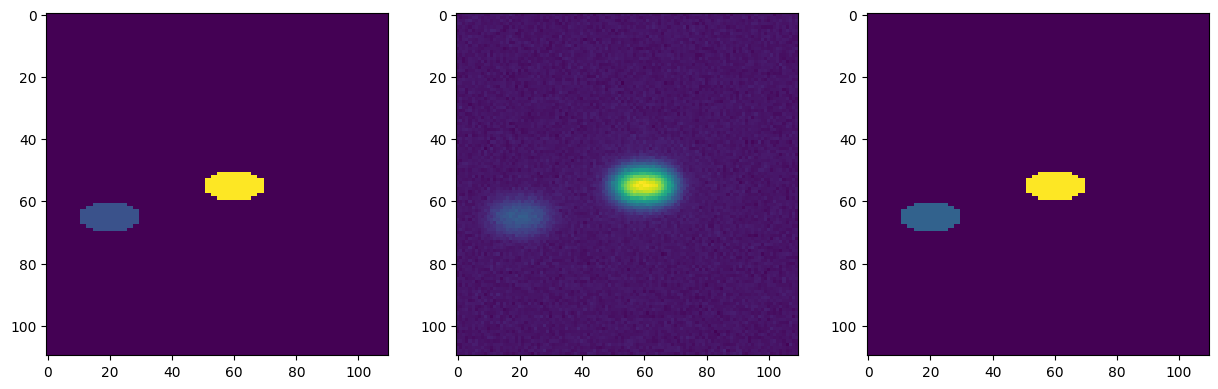

In [32]:
f, axarr = plt.subplots(1,3)
axarr[0].imshow(ori)
axarr[1].imshow(out)
axarr[2].imshow(oldOut)
plt.show()


array([[1., 1.],
       [1., 1.]])

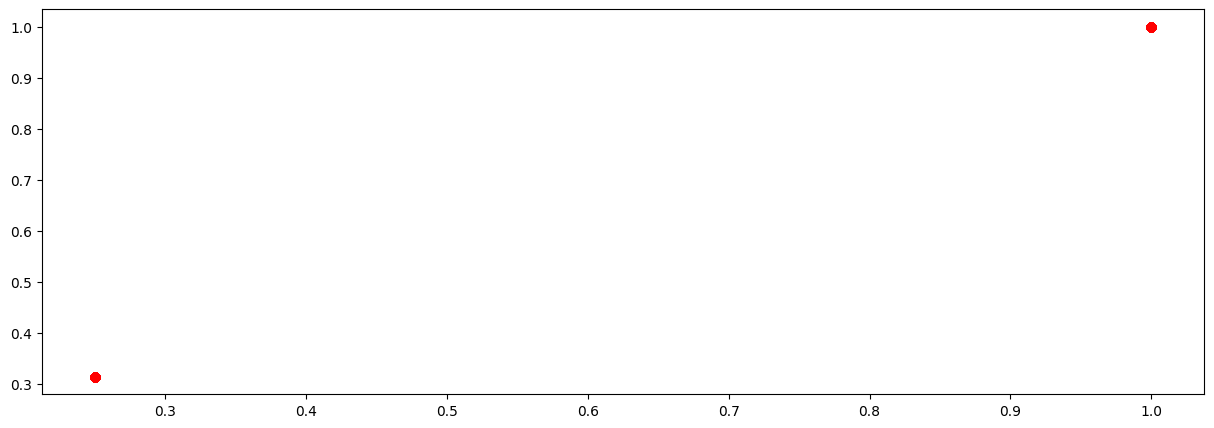

In [33]:
original_intensity = []
custom_intensity = []


for x in sourcePts:
    original_intensity.append(ori[x[0],x[1]])
    custom_intensity.append(oldOut[x[0],x[1]])

plt.plot(original_intensity,custom_intensity,'ro')

#Calculate correlation coefficient
np.corrcoef(original_intensity,custom_intensity)